<a href="https://colab.research.google.com/github/ninavdPipple/BERTopic/blob/master/Small_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install typing_extensions --upgrade
!pip install bertopic
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired
!pip install kora -q
from kora import drive
drive.link_nbs()
from Evaluation_BERTopic_repo import Trainer, DataLoader, Evaluator
!python -m pip install tomotopy
!pip install octis
from octis.dataset.dataset import Dataset
import os
import requests
import json
import numpy as np
!pip install openai
import openai
from openai import AzureOpenAI
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', -1) # make sure to print entire messages when printed form dataframe
import regex as re

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 16.1 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 8.1 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039301 sha256=315574f336f135095d85e76adde7fe97d33d2c1b15c08835a7602daa59a1b94f
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
  Created wheel for umap-

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Connecting to GPT model

client = AzureOpenAI(
    api_key="139ff4ea58234550972e6f5db98b30a7",
    api_version='2023-05-15',
    azure_endpoint = "https://510-openai.openai.azure.com/"
)

deployment_name='510-chat' #This will correspond to the custom name you chose for your deployment when you deployed a model.

In [4]:
# Pick model for output
model = 'Low_preprocess'

# Create folder if model doesn't exist yet
new_model = not os.path.exists(f"/content/drive/MyDrive/2024/{model}")
if new_model:
   os.makedirs(f"/content/drive/MyDrive/2024/{model}")

In [5]:
# from IPython.display import display, HTML

# examples = raw_data[['text', 'label']].iloc[[565,1448,456]]

# def pretty_print(df):
#     return display( HTML( df.to_html().replace("\\n","<br>")))

# pretty_print(examples)

In [6]:
# # Load data
# raw_data = pd.read_excel('/content/drive/MyDrive/messages_2023_list.xlsx')

# # # Pick small subset if performing costly operations
# # if model == 'Model_small_data':
# #   raw_data = raw_data.iloc[:100]

# # Remove enters in label names
# raw_data['label'] =  raw_data['label'].apply(lambda x: re.sub(r'\n','', str(x)))

# # Remove urls
# print('Instances containing https: ', sum(raw_data['text'].str.contains(r'https')))
# raw_data['text'] = raw_data['text'].apply(lambda x: re.sub(r'\(https[^\)]*\)',' <URL> ', str(x))) # Remove based on brackets
# raw_data['text'] = raw_data['text'].apply(lambda x: re.sub(r'https[\S]*','<URL>', str(x))) # Remove based on followed by a space or enter

# # Remove any remaining Ukrainian text
# print('Instances containing Ukrain: ', sum(raw_data['text'].str.contains(r'[А-ЩЬЮЯҐЄІЇа-щьюяґєії]')))
# print(raw_data.text[raw_data['text'].str.contains(r'[А-ЩЬЮЯҐЄІЇа-щьюяґєії]')])
# raw_data['OCTIS'] =  raw_data['text'].apply(lambda x: re.sub(r'\p{IsCyrillic}','', str(x)))

# # Manually remove <> if they are not around any of the markers (PERSON, URL, ect)
# def remove_markers(text):
#     pattern = r'<(?!PERSON>|URL>|CREDIT_CARD>|EMAIL_ADDRESS>|PHONE_NUMBER>)(.*?)>'
#     cleaned_text = re.sub(pattern, r'\1', text)
#     return cleaned_text

# # raw_data['OCTIS'] = raw_data['OCTIS'].apply(remove_markers)

# # Remove enters within message and save
# raw_data['OCTIS'] =  raw_data['OCTIS'].apply(lambda x: re.sub(r'\n',' ', str(x)))

# raw_data['OCTIS'].to_csv('/content/drive/MyDrive/2024/documents_stripped.csv', index=False, encoding="utf-8-sig")
# raw_data['label'].to_csv('/content/drive/MyDrive/2024/labels.csv', index=False, encoding="utf-8-sig")
# raw_data.to_csv('/content/drive/MyDrive/2024/raw_data.csv', index=False, encoding="utf-8-sig")

In [7]:
raw_data = pd.read_csv('/content/drive/MyDrive/2024/raw_data.csv', encoding="utf-8-sig")

In [8]:
# import string
# # from octis.preprocessing.preprocessing import Preprocessing
# from OCTIS_preprocess_repo import Preprocessing
# os.chdir(os.path.pardir)

# # Initialize preprocessing
# preprocessor = Preprocessing(lowercase=False,
#                 remove_punctuation=False,
#                 punctuation=string.punctuation,
#                 remove_numbers=False,
#                 lemmatize=False,
#                 language="english",
#                 split=False,
#                 verbose=True,
#                 save_original_indexes=True,
#                 remove_stopwords_spacy=False,)

# # preprocess
# dataset = preprocessor.preprocess_dataset(documents_path=r'/content/drive/MyDrive/2024/documents_stripped.csv', labels_path=r'/content/drive/MyDrive/2024/labels.csv')

# # save the preprocessed dataset
# dataset.save('/content/drive/MyDrive/2024/ukraine')

In [9]:
# Load a dataset
dataset = Dataset('ukraine')
dataset.load_custom_dataset_from_folder('/content/drive/MyDrive/2024/ukraine')
list_data = dataset.get_corpus()
data = [" ".join(words) for words in list_data]

In [68]:
# import random
# import time
# n = 20
# sample_ids = random.sample(range(len(data)),n)
# sample = pd.DataFrame({'Ids': sample_ids, 'Original': np.array(data)[sample_ids], 'Reformulation': np.repeat('', n)})

# delay_in_seconds=1 # Delay in between subsequent prompts to avoid RateLimitError of OpenAI
# prompt_format = """
# I have a Telegram message that looks as follows: [MESSAGE]

# Based on the information above, please rewrite the Telegram message while keeping the pronoun the same in the following format:
# Message: <reformulation>
# """

# for i, message in enumerate(sample.Original):
#   prompt = prompt_format.replace('[MESSAGE]', message)
#   messages = [{"role": "system", "content": "You are a helpful assistant."},
#       {"role": "user", "content": prompt}]
#   kwargs = {"model": deployment_name, "messages": messages}

#   response = client.chat.completions.create(**kwargs)
#   reformulation = response.choices[0].message.content.strip().replace("Message: ", "")
#   reformulation = reformulation.replace("<Reformulation> ","")
#   reformulation = reformulation.replace("<reformulation> ","")
#   reformulation = reformulation.replace("Reformulation: ","")

#   sample.Reformulation.iloc[i] = reformulation
#   time.sleep(delay_in_seconds)

# sample.to_csv('/content/drive/MyDrive/2024/reformulations.csv', index=False, encoding="utf-8-sig")

In [69]:
sample = pd.read_csv('/content/drive/MyDrive/2024/reformulations.csv')
print(sample)

     Ids  \
0   1421   
1   1462   
2   3899   
3   1576   
4   3427   
5   480    
6   4026   
7   3070   
8   4505   
9   811    
10  309    
11  1304   
12  939    
13  4423   
14  328    
15  1172   
16  4046   
17  597    
18  3632   
19  1407   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Original  \
0   "Hello. Girls who received at the Railway Station Mix, what are the terms of use, otherwise something I can not understand?"                                                                                                                                                            

In [12]:
# Analyze data

# # Overview of categories
# plt.figure().set_figheight(7)
# sns.countplot(y = 'label', data=raw_data, order = raw_data['label'].value_counts().index)
# plt.title('Messages per category')
# plt.xlabel('Amount of messages')
# plt.ylabel('Label')
# plt.show()


In [13]:
# #%%
# words = [re.sub('[^a-z]','',word.lower()) for message in list_data for word in message] # Remove punctuation and digits and lowercase all words
# no_stops = [word for word in words if word not in stopwords.words('english')] # Exclude stopwords
# counts = Counter(no_stops)
# print(counts.most_common(50))

In [14]:
# # Analyse lenght of messages
# lengths = [len(message) for message in list_data]
# print('Max lenght:', max(lengths))
# print('Min lenght:', min(lengths))
# longest_messages = (-np.array(lengths)).argsort()[:10]
# sns.histplot(lengths)
# plt.title('Distribution of message sizes')
# plt.xlabel('Number of words')
# plt.ylabel('Amount of messages')
# plt.xticks(np.arange(0,550,50))
# plt.show()

In [15]:
from sentence_transformers import SentenceTransformer

# Pick embedder
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embedding_model.max_seq_length = 512

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
# import torch

# tokenizer = embedding_model.tokenizer

# # Tokenize sentences
# tokenized_messages = tokenizer(data, padding=True, truncation=False, return_tensors='pt')

# # Check how many messages cut-off by truncation of SBERT

# num_tokens = torch.sum(tokenized_messages['input_ids'] > 0, dim=1)
# # sns.histplot(num_tokens)
# num_tokens = pd.Series(num_tokens)
# bins = [0,256,512,1000] # Default truncation is after 256 and can be adjusted to max 512
# num_tokens.value_counts(bins=bins)
# print(num_tokens.value_counts(bins=bins))

# # Truncation has barely any result. Also because urls blanked and digits removed

In [17]:
# # Pre-calculate embeddings

# # Prepare data
# data = [" ".join(words) for words in dataset.get_corpus()]

# # Calculate embeddings
# embeddings = embedding_model.encode(data, show_progress_bar=True)

# # Save embeddings
# with open('/content/drive/MyDrive/2024/embeddings.npy', 'wb') as f:
#     np.save(f, embeddings)


In [18]:
# Load embeddings
with open('/content/drive/MyDrive/2024/embeddings.npy', 'rb') as f:
    embeddings = np.load(f)

In [19]:
# Fix UMAP model with random state

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, low_memory = False, metric='cosine',random_state=1)

In [20]:
# import gensim.downloader as api

# word2vec_model = api.load('word2vec-google-news-300')
# word2vec_model.save('/content/drive/MyDrive/2024/word2vec_model.kv')

In [21]:
from gensim.models import KeyedVectors
word2vec_model = KeyedVectors.load('/content/drive/MyDrive/2024/word2vec_model.kv')

doc_ids = range(len(data))

In [22]:
# documents = pd.DataFrame({"Document": data,
#                           "ID": doc_ids,
#                           'Class':  raw_data['label']})

# baseline_evaluator =  Evaluator(documents, embeddings, topic_model = BERTopic(umap_model= umap_model), name = 'Original labeling', dataset =dataset, word2vec_model=word2vec_model)

# baseline_evaluator.score(save= f"/content/drive/MyDrive/2024/Original_ukraine")


In [23]:
# Create class numbers for each label
label_to_num = {k: v for v, k in enumerate(pd.Series(raw_data['label']).unique())}
raw_data['label_num'] = raw_data['label'].map(label_to_num)

In [24]:
# # Remove multiple occurences of the same character
# # from Tweettokenizer
#     pattern = re.compile(r"(.)\1{2,}")
#     return pattern.sub(r"\1\1\1", text)

In [82]:
import joblib
np.random.seed(1)

if True:
    for i in range(1):
        params = {
            'embedding_model': 'all-MiniLM-L6-v2',
            'verbose': True,
            'umap_model': umap_model,
            'hdbscan_model': HDBSCAN(min_cluster_size=10, prediction_data=True, metric='euclidean', cluster_selection_method='eom', gen_min_span_tree=True), # min cluster size by default 10
            'vectorizer_model': CountVectorizer(stop_words="english", ngram_range=(1, 2)), # default only ngram (1,1)
            # 'representation_model': KeyBERTInspired(), # strongly influences measures depending on topic words
        }

        trainer = Trainer(dataset='/content/drive/MyDrive/2024/ukraine',
                          model_name="BERTopic",
                          params=params,
                          bt_embeddings=embeddings,
                          custom_dataset=True,
                          verbose=True,
                          word2vec_model=word2vec_model,
                          semi_supervised=False,
                          labels = raw_data['label_num'])
        results, topic_model = trainer.train(save=f"/content/drive/MyDrive/2024/{model}/BERTopic_train_{i+1}")


    # Save model
    pointer_embedding = "sentence-transformers/all-MiniLM-L6-v2"
    topic_model.save(f'/content/drive/MyDrive/2024/{model}.joblib', serialization="pickle", save_ctfidf=True, save_embedding_model=pointer_embedding)

    # Seperately save hdbscan/umap model to perserve information
    joblib.dump(topic_model.hdbscan_model, f'/content/drive/MyDrive/2024/{model}/hdbscan.joblib')
    joblib.dump(topic_model.umap_model, f'/content/drive/MyDrive/2024/{model}/umap.joblib')

2024-02-14 09:13:06,244 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-14 09:13:18,277 - BERTopic - Dimensionality - Completed ✓
2024-02-14 09:13:18,279 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-14 09:13:19,849 - BERTopic - Cluster - Completed ✓
2024-02-14 09:13:19,858 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-14 09:13:20,546 - BERTopic - Representation - Completed ✓
2024-02-14 09:13:24,528 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Results
npmi: 0.008816999544757015
we: -0.004511967900568843
diversity: 0.40714285714285714
kl background: 1.4679230882432706
 


In [88]:
# Load model
topic_model = BERTopic.load(f'/content/drive/MyDrive/2024/{model}.joblib')
# topic_model.hdbscan_model = joblib.load(f'/content/drive/MyDrive/2024/{model}/hdbscan.joblib')
# topic_model.umap_model = joblib.load(f'/content/drive/MyDrive/2024/{model}/umap.joblib')

# Obtain results
document_info = topic_model.get_document_info(data)

In [89]:
reformulation_topics, reformulation_dist = topic_model.transform(sample.Reformulation)
print(reformulation_dist[0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-02-14 09:14:41,610 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-02-14 09:14:42,614 - BERTopic - Dimensionality - Completed ✓
2024-02-14 09:14:42,620 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-02-14 09:14:42,625 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2024-02-14 09:14:42,655 - BERTopic - Probabilities - Completed ✓
2024-02-14 09:14:42,657 - BERTopic - Cluster - Completed ✓


[1.29255383e-10 5.41688980e-10 3.04078013e-06 2.42202064e-10
 3.11510162e-06 4.44825447e-08 9.24006247e-11 5.23659192e-10
 6.53337935e-10 5.81676569e-10 2.55083762e-06 6.52407092e-10
 5.90906650e-10 5.37952558e-10 1.39713896e-10 4.58300536e-10
 6.19137447e-10 5.06753871e-10 6.36597209e-10 6.00962996e-10
 1.36720970e-01 5.70721695e-10 4.90453366e-10 1.30231285e-01
 5.11187062e-10 7.25796267e-10 4.66339631e-10 2.76561540e-09
 2.66921767e-10 5.04673765e-10 3.23440675e-06 5.94956461e-10
 4.71163401e-10 5.19927174e-10 6.94084253e-10 5.95010715e-10
 3.94035202e-08 1.11443435e-01 4.81887424e-10 5.65951944e-10
 5.96864618e-10 1.87518318e-01 4.12368563e-08 3.46229945e-06
 5.81961950e-10 7.47497603e-10 2.61745310e-09 5.29948408e-10
 3.76636616e-06 4.77681324e-10 5.38268364e-10 5.78044549e-10
 3.66106854e-06 2.32821914e-10 6.47311152e-10 1.41973684e-10
 2.67368519e-06 4.83119497e-10 2.80848914e-09 5.01785980e-10
 6.38554427e-10 5.61130833e-10 2.89901599e-06 2.47328372e-10
 3.04305009e-06 2.738786

In [90]:
print(topic_model.probabilities_)

[[5.59736152e-003 6.19519851e-003 4.26592349e-003 ... 1.81400527e-002
  4.71608580e-003 1.03459782e-002]
 [9.01650502e-308 6.66884076e-308 4.92357398e-307 ... 9.34981643e-308
  1.73912778e-307 8.75554099e-308]
 [7.39421464e-003 4.76013707e-003 3.23845105e-001 ... 6.00407323e-003
  1.19993538e-002 5.86485444e-003]
 ...
 [4.24300391e-001 9.02677989e-003 5.48463365e-003 ... 8.61422617e-003
  5.22670154e-003 9.82970761e-003]
 [1.17073930e-307 1.56037077e-307 8.58650147e-308 ... 7.51949153e-307
  9.83098550e-308 2.64048458e-307]
 [4.32017241e-003 4.77164629e-003 2.94346121e-003 ... 1.29158582e-002
  3.24550644e-003 8.10929243e-003]]


In [ ]:
#%%

# Analyse results
print(topic_model.get_topic_info())
print(document_info)

    Topic  Count                                                 Name  \
0  -1      1269   -1_tell_good_hello_person                             
1   0      256    0_card_bank_money_account                             
2   1      135    1_parcel_send_transfer_send parcel                    
3   2      133    2_payments_received_red cross_red                     
4   3      92     3_dog_documents_rabies_animals                        
.. ..      ..                                ...                        
80  79     12     79_bulgarian_bulgarian language_courses_suggest       
81  80     12     80_hotel_hostel_accommodation hello_hostels           
82  81     11     81_viber_viber telegram_phone_number_telegram         
83  82     11     82_hygiene_food hygiene_food_received hygiene         
84  83     10     83_bucharest_tell bucharest_bucharest good_cleaning   

                                                                                                                           

In [ ]:
documents = pd.DataFrame({"Document": data,
                          "ID": doc_ids,
                          'Class':  document_info['Topic']})

bertopic_evaluator =  Evaluator(documents, embeddings, topic_model = topic_model, name = 'BERTopic', dataset =dataset, word2vec_model=word2vec_model)

bertopic_evaluator.score(save= f"/content/drive/MyDrive/2024/{model}/BERTopic_ukraine_1")

Results
npmi: 0.006434107676214941
we: -0.004108529542785837
diversity: 0.40705882352941175
 


In [ ]:
from sklearn.metrics.cluster import pair_confusion_matrix

# Calculate RRI

def RRI(topics, labels, leave_out = [-1]):
  """
  Caluclates the refinement Rand Index score while leaving out some topics

  Input:
  topics: the refined topics
  labels: the original labeling
  leave_out: a  list of topic numbers to hold out. By default only exclude outliers

  Returns the Refinement Rand Index
  """
  # Exclude the specified topics
  labels = labels[~topics.isin(leave_out)]
  topics = topics[~topics.isin(leave_out)]

  # Measure on refinement; inspired on Rand Index
  contingency = pair_confusion_matrix(topics, labels)
  RRI = contingency[1][1]/(contingency[1][1]+contingency[1][0]+contingency[0][0])
  return RRI

print(RRI(document_info['Topic'], raw_data['label']))

0.011225393141892307


In [ ]:
# Calculate DBCV
DBCV = topic_model.hdbscan_model.relative_validity_

0.30369142817361355

In [ ]:
# from OpenAI_BERTopic_repo import OpenAI

# summarization_prompt = """
# This is a list of texts where each collection of texts describe a topic. After each collection of texts, a summary that captures the most important content of the texts in the collections is provided.
# ---
# Topic:
# Sample texts from this topic:
# - Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
# - Meat, but especially beef, is the worst food in terms of emissions.
# - Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

# Keywords: meat beef eat eating emissions steak food health processed chicken
# Summary: Meat has become a bigger component of our diets. Eating meat is harmful for the enviroment.
# ---
# Topic:
# Sample texts from this topic:
# - I have ordered the product weeks ago but it still has not arrived!
# - The website mentions that it only takes a couple of days to deliver but I still have not received mine.
# - I got a message stating that I received the monitor but that is not true!
# - It took a month longer to deliver than was advised...

# Keywords: deliver weeks product shipping long delivery received arrived arrive week
# Summary: Some packages take a long time to get delivered. False claims about the delivery of packages are being made.
# ---
# Topic:
# Sample texts from this topic:
# [DOCUMENTS]
# Keywords: [KEYWORDS]
# Summary:"""

# representation_model= OpenAI(client,model = deployment_name, prompt = summarization_prompt, nr_docs=20, delay_in_seconds=3)
# representation_model.extract_topics(topic_model, documents.rename(columns={'Class':'Topic'}), topic_model.c_tf_idf_, topic_model.topic_representations_)

In [ ]:
# Select cluster to analyse
cluster_num = 36

In [ ]:
from OpenAI_BERTopic_repo import OpenAI

summarization_chat_prompt = """
I have a topic that is described by the following keywords: [KEYWORDS]
In this topic, the following documents are a small but representative subset of all documents in the topic:
[DOCUMENTS]

Based on the information above, please write a summary that captures the most important content of this topic in the following format:
topic: <summary>
"""

representation_model = OpenAI(client, model=deployment_name, chat=True, prompt=summarization_chat_prompt, nr_docs=20, delay_in_seconds=3)
representation_model.extract_topics(topic_model, documents[documents['Class']==cluster_num].rename(columns={'Class':'Topic'}), topic_model.c_tf_idf_.getrow(cluster_num), {cluster_num:topic_model.topic_representations_[cluster_num]})

100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


{36: [('Discussion about light and electricity issues in various districts, inquiries about groups and branches affected by lights being turned off, requests for information about when lights will be turned back on, and questions about whether certain services, such as the NP, work without electricity.',
   1)]}

In [ ]:
print(topic_model.get_topic_freq().head(11))

    Topic  Count
4  -1      1269 
3   0      256  
49  1      135  
2   2      133  
36  3      92   
19  4      89   
52  5      87   
83  6      81   
75  7      81   
55  8      80   
0   9      79   


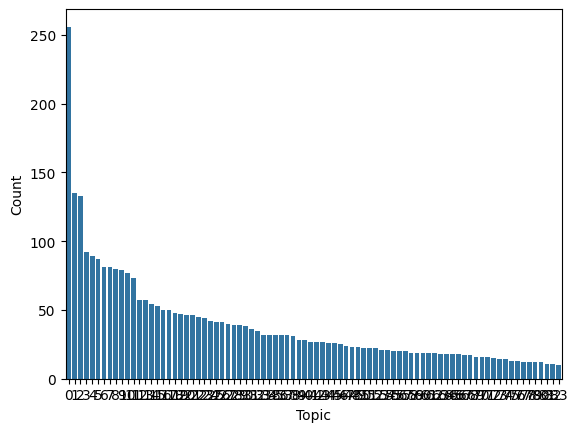

In [ ]:
# Overview of cluster sizes
sns.barplot(y = 'Count', x = 'Topic', data=topic_model.get_topic_freq().iloc[1:])
plt.show()


In [ ]:
# Check biggest cluster
print(document_info['Document'][document_info['Topic']== 0])

3       "Hello) who suspended 500+ due to departure from Poland (up to 30 days). What did you do? How quickly did the funds come? I called the zus hotline, they just waited..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
20      "Hello. Tell me please, maybe som

In [ ]:
# Analyze clusters of large text messages

print(raw_data['text'].iloc[longest_messages])
print(document_info['Topic'].iloc[longest_messages])

# Check specific cluster
print('Longest cluster:', document_info['Top_n_words'].iloc[longest_messages[0]])
print(document_info['Document'][document_info['Topic']== document_info['Topic'].iloc[longest_messages[0]]])

1977    "**How to cancel temporary protection issued by Slovakia** ❓\n\nIf you are in Bratislava, submit an application to the police station on Botova 7, and if in another city - write to us and we will find out where to approach you. \n\n**Where to get the application** ❓\n\nOn Botov 7 - with lawyers (they can help fill it out), in other cities - right in the department that will consider your application. \n\nWe also attach a link to the application form [**HERE](<URL>)**. \n\n**What other documents need to be submitted** ❓\n\nThe police need to provide a copy or original of your temporary protection (odidenec/docasne utocisko). \n\nWe recommend providing a copy and keeping the original to yourself. If you give the original - make yourself a copy or photo.\n \n**Where to find <PERSON> and identifikátor ❓\n** \nThis data is indicated on your temporary protection document. \n\n**How long will the police review the❓ application** \n\nAs a general rule, the police consider the applicati

In [ ]:
fig = topic_model.visualize_topics()
fig.write_html("inter.html")
fig.show()

In [ ]:
heatmap = topic_model.visualize_heatmap()
heatmap.show()

In [ ]:
# Check specific cluster
print(document_info['Document'][document_info['Topic']== 74])

418     "Go to the IRC, and let them conduct an examination, appoint a psychologist to the child on the basis of the kindergarten As for bullying, did you try to solve this issue through a kindergarten teacher / director? As for the circles, there are a lot of state ones, they do not work in the summer, but it is better to clarify As for self-defense, it is possible and worth learning ,but it seems to me that in your case we are talking about psychological help more than physical help Feel sorry for😒 your daughter All these attacks, children do not know from which city you are ... Here are more questions about the atmosphere in the group"                                                                                                                                                                                                                                                                                                                                                                  

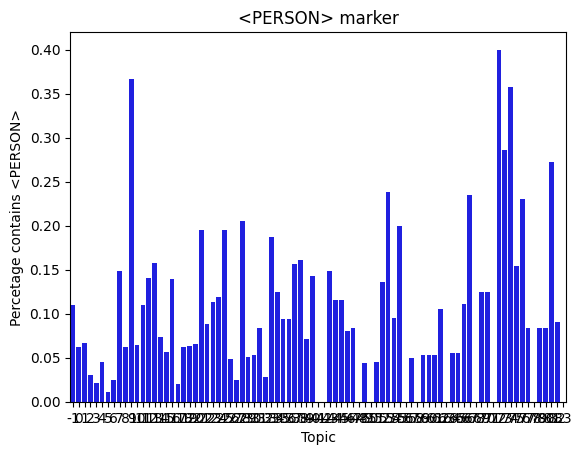

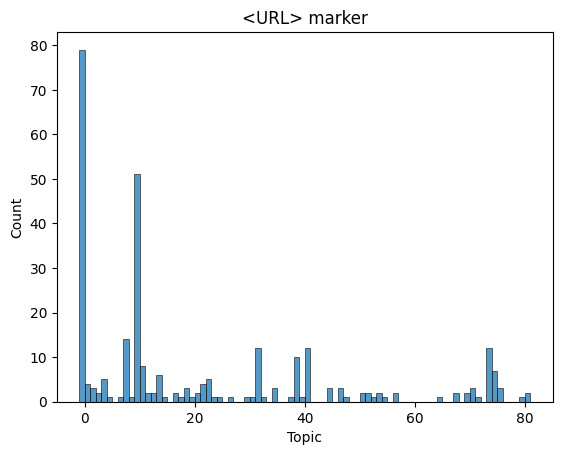

In [ ]:
#%%

# Check if not focussing on marker tokens
# Could potentionally check with tf-idf score
# Now because of preprocessing punctuation is removed, so markers not this specific anymore

pers_topics = pd.concat([document_info['Topic'],raw_data['text'].str.contains('<PERSON>')],axis=1)
freq_pers = pers_topics.groupby(['Topic'], as_index=False).mean()
sns.barplot(x = 'Topic', y= 'text', data=freq_pers, color='b')
plt.title('<PERSON> marker')
plt.ylabel('Percetage contains <PERSON>')
plt.show()

url_topics = document_info['Topic'][raw_data['text'].str.contains('<URL>')]
sns.histplot(url_topics, binwidth=1)
plt.title('<URL> marker')
plt.show()

In [ ]:
# Get matrix with for every word the importance for that topic and the corresponding words
topic_term_matrix = topic_model.c_tf_idf_.toarray()
words = topic_model.vectorizer_model.get_feature_names_out()

# Get the column corresponding to person
person_col = np.where(words=='person')[0]

# Get for each topic the ranking on how important person is
person_importance = np.where(np.argsort(-topic_term_matrix)==person_col)[1]

# Get the ranking for the topic where it's most important (exclude the outliers)
max_importance = np.min(person_importance[1:])
print(max_importance)

14


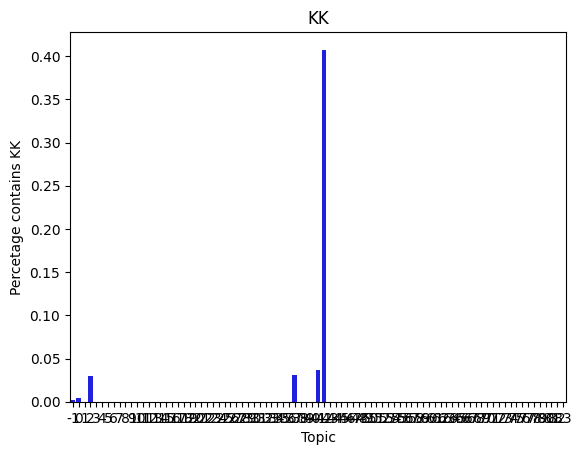

In [ ]:
KK_topics = pd.concat([document_info['Topic'],raw_data['text'].str.contains(' KK ')],axis=1)
freq_KK = KK_topics.groupby(['Topic'], as_index=False).mean()
sns.barplot(x = 'Topic', y= 'text', data=freq_KK, color='b')
plt.title('KK')
plt.ylabel('Percetage contains KK')
plt.show()


In [ ]:
#%%

# Ditribution over topics

topic_distr, _ = topic_model.approximate_distribution(data, window=8, stride=4)
topic_model.visualize_distribution(topic_distr[0], custom_labels=True)

# Maybe nice for long messages

100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


In [ ]:
instance = 3121

# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(data, calculate_tokens=True)

# Visualize the token-level distributions
topic_model.visualize_approximate_distribution(data[instance], topic_token_distr[instance])

100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


,Tell,me,where,to,make,vinete,From,whom,At,the,border,the,officers,in,Starokowhy,answered,we,do,not,know
3_dog_documents_rabies_animals,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.167,0.335,0.335,0.335,0.167,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
15_passport_child_passport good_foreign passport,0.103,0.217,0.217,0.217,0.115,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
32_child_poland_ukraine_passport,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.153,0.306,0.306,0.306,0.153,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [ ]:
topics_per_class = topic_model.topics_per_class(raw_data['text'], classes=raw_data['label'])

fig = topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=None)
# fig.write_html("class.html")
fig.show()

29it [00:01, 18.22it/s]


In [ ]:
raw_data[['text', 'label']][document_info.Topic==79]

,text,label
2609,"Good afternoon, whose children go to the Bulgarian school, tell me, children at school as listeners or at the end of the school year receive a report card / certificate?",EDUCATION
2833,"I am looking for courses or a tutor in Bulgarian for a child of 10 years. Sofia, but you can also online.",TRANSLATION/LANGUAGE
2842,"Hello! I am looking for a Bulgarian tutor (distance learning)! I will be glad to suggestions, have a good day 🙏 everyone",TRANSLATION/LANGUAGE
2916,Good afternoon! Who can suggest really good courses for quick learning Bulgarian,TRANSLATION/LANGUAGE
2927,"Good evening, can anyone teach Bulgarian (Russian speakers)?🤔Write in ls",TRANSLATION/LANGUAGE
2942,"""""""Attention!!! 📢📢📢\nWe invite everyone from 18 years and more to a live study of the Bulgarian language, which will be conducted by a leading specialist in Bulgaria 🇧🇬 (currently an assistant at the Department of Foreign Languages of the University, Prof. Dr. <<PERSON>>, Burgas)\n<PERSON>nova.\n\nThe first lesson will take place on Wednesday 8.02.23!\nClasses will be held offline in two groups: the first group at 16.30, the second group at 17.30. The duration of the lesson is 40 minutes. The value of the lesson is 5 leva. 🦁\n\nPre-registration is very welcome! You can sign up by phone. (<PERSON>r)\n<PHONE_NUMBER> - <PERSON>. \nThe number of places is limited! 😉\nWe are waiting for you all at the address Nessebar, hotel Camelot Residence, room. 37.\n<URL>\n\nSubscribe to """"""""Wings of Kindness""""""""\n<URL>""""""\t\t\n\t\t\n\t\t",TRANSLATION/LANGUAGE
2948,"Hello everyone)\nTell me, please, how are any free Bulgarian courses for Ukrainians possible?\nWhere to look",TRANSLATION/LANGUAGE
2974,"Hello, I am looking for a teacher of the Bulgarian language for yourself, write in person, Thank you.",TRANSLATION/LANGUAGE
2984,"Or can you suggest, be kind, sites or videos by which you can learn Bulgarian?",TRANSLATION/LANGUAGE
2997,"""Good afternoon \nPlease tell me if the courses in Sofia of the Bulgarian language""",TRANSLATION/LANGUAGE


In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(raw_data['text'])
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 83/83 [00:00<00:00, 106.52it/s]


In [ ]:
# Assign an original label to topics if more than a threshold percentage of the messages in the topic originate from that label

threshold = 0.7
raw_data['topic']= document_info['Top_n_words']
clustered_only = raw_data[document_info['Topic']!=-1] # Exclude outliers

# Count the number of occurences of each label within each topic
label_count = clustered_only[['topic', 'label']].groupby(['topic', 'label']).size().reset_index(name='count')

# Obtain the frequency how much of the topic originated from which label
label_count['freq'] = label_count.groupby(['topic'])['count'].apply(lambda x: x / x.sum()) # DataFrame containing per topic the distribution over the original labels

# Say a topic is a refinement if more that the threshold originated from the same label
clear_refined = label_count[label_count['freq']>=threshold][['label', 'freq', 'topic']]
print(str(len(clear_refined)), ' topics originate clearly from refinement on labeling')
print(clear_refined.groupby(['label'])['label', 'topic'].apply(print))


35  topics originate clearly from refinement on labeling
       label  \
468  ANOMALY   

                                                                                                                                           topic  
468  vaccination - certificate - vaccination certificate - european - covid - medical - worldwide - valid worldwide - medical examination - diya  
        label  \
225  CHILDREN   
420  CHILDREN   

                                                                                                                topic  
225  nanny - looking babysitter - babysitter - looking nanny - looking - son - years - old - years old - child months  
420  sports - sections - football - sports sections - coach - children - tennis - boxing - knows sports - recommend    
            label  \
176  CONNECTIVITY   
203  CONNECTIVITY   

                                                                                                              topic  
176  internet - sim - 

In [ ]:
# Get topics that are not from a parcticular label

potential_new = label_count[label_count['freq']<threshold][['label', 'freq', 'topic']]
covered_topics = clear_refined['topic'].tolist()

# Exclude refinement topics
potential_new = potential_new[~potential_new['topic'].isin(covered_topics)]

# Order topics based on being least certain to be part of the refinement
potential_new = potential_new.groupby('topic')['freq'].max().reset_index(name='certainty') # Get the assignment score to the label it was most likely to occur
potential_new = potential_new.sort_values('certainty')
print(potential_new)


                                                                                                                                                                   topic  \
46  url - assistance - 00 - displaced - persons - url assistance - assistance ukrainians - humanitarian - ukrainians - form                                                
4   bucharest - tell bucharest - bucharest good - cleaning - helps housing - oatmeal thank - budget grateful - girl 19 - need accommodation - oatmeal                      
21  moldova - republic - republic moldova - voted - passport - border - cross border - 90 - moldovan - possible                                                            
1   bratislava - job bratislava - bratislava good - looking - job - tell bratislava - bratislava hello - bratislava buy - buy - good                                       
7   chisinau - chisinau tell - chisinau good - utilities did - time banks - service chisinau - chisinau pay - banks accept - yandex - pay ut

In [ ]:
document_info['Document'][document_info['Top_n_words'] ==  potential_new['topic'].iloc[0]]

0       "Hello everyone! Regarding help from the Good Samaritan (Hope for Ukraine) in Lviv. It is worth subscribing to them on Facebook: from time to time they post a form that must be filled out to receive assistance. Assistance is issued only once. 📎 It is necessary to register in the form separately for separate emails. Each child on a different email. It happens that they do not have time to register all family members, because the form closes quickly. After successful registration, a confirmation comes to the email, which indicates the address, date and time of receipt. 📎 Then you need to come to Vynnyky on Lisna, 1 — bus number 29 runs from Lviv railway station for an hour. Delivery on the territory of the church ""Good Samaritan"". No matter the weather, everyone is waiting outside. 📎 The room is launched alphabetically, so if you have an issue from 10:00, then you need to come exactly at 10, and then follow which letters enter. If you miss your letter, you can enter after the e

In [ ]:
# from sklearn.metrics import silhouette_score

# # Obtain the umap embeddings
# umap_embeddings = topic_model.umap_model.transform(embeddings)

# # Exclude outliers
# umap_embeddings = umap_embeddings[document_info['Topic']!=-1]
# clustering = document_info['Topic'][document_info['Topic']!=-1]

# # Calculate silhouette score
# print(silhouette_score(umap_embeddings, clustering))


0.04934822
